# Experiment 18 - Concatenated Input

## Model creation

In [13]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini/'

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [5]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image.reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    tmp_images.append(rgb_image)
  tmp_images = np.array(tmp_images)
  return tmp_images

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
abnormality_images = images[1::2]
baseline_images = images[0::2]

In [ ]:
def concatenate_abnormality_baseline(abnormality_images, baseline_images):
  images = []
  for (abnormality, baseline) in zip(abnormality_images, baseline_images):
    images.append(np.concatenate((abnormality.reshape((150,150,1)), baseline.reshape((150,150,1))), axis=2))
  images = np.array(images)
  return images

images = concatenate_abnormality_baseline(abnormality_images, baseline_images)
print(images.shape)

(2676, 150, 150, 2)


In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import gray2rgb

import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
from keras.layers import Input
from keras import Model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

def inception_module_6a(layer_in, depth=224):
  
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv5 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv4)
  conv6 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv7 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv3, conv6, conv7], axis=-1)
  return layer_out

def inception_module_7a(layer_in, depth=224):
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  conv5 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv6 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  conv7 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv6)
  conv8 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv7)
  conv9 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv8)
  pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv10 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv4, conv9, conv10], axis=-1)
  return layer_out

def inception_module_6b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def inception_module_7b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def getDCNN(input):
  layer1 = layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(input)
  layer3 = layers.Conv2D(32,(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer1)
  layer4 = layers.Conv2D(64,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer3)
  layer5 = layers.MaxPooling2D((2,2), padding="same")(layer4)
  layer6 = layers.Conv2D(80,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer5)
  layer7 = layers.Conv2D(192,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer6)#concatenate after
  layer8 = layers.MaxPooling2D((2,2))(layer7)
  layer9 = inception_module_6a(layer8,depth=56)
  layer10 = inception_module_6a(layer9,depth=56)#concatenate after
  layer11 = inception_module_6b(layer10,depth1=144,depth2=144)
  layer12 = inception_module_7a(layer11,depth=128)
  layer13 = inception_module_7a(layer12,depth=128)# concatenate after
  layer14 = inception_module_7b(layer13,depth1=192,depth2=192)
  layer15 = layers.AveragePooling2D((8,8))(layer14)
  
  layer7_1 = layers.AveragePooling2D((72,72))(layer7)
  layer10_1 = layers.AveragePooling2D((36,36))(layer10)
  layer13_1 = layers.AveragePooling2D((17,17))(layer13)

  layer_out = concatenate([layer7_1, layer10_1, layer13_1,layer15], axis=-1)
  return layer_out

def getModel():
  input = Input(shape=(150, 150, 2))
  dcnn1 = getDCNN(input)
  dcnn2 = getDCNN(input)
  concatenation = concatenate([dcnn1, dcnn2], axis=-1)
  flattener = layers.Flatten()(concatenation)
  dense1 = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(flattener)
  dense2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense1)
  dense3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense2)
  output_layer = layers.Dense(1, activation='sigmoid')(dense3)
  model = Model(inputs=input, outputs=output_layer)
  model.summary()
  return model

In [ ]:
from keras.layers import Input
from keras import applications


model = getModel()
model.summary()


# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]


datagen = ImageDataGenerator(
    validation_split=0.2 ,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator(validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)



STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 2) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 148, 148, 32) 608         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 148, 148, 32) 608         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 147, 147, 32) 4128        conv2d_94[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2141, 150, 150, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (535, 150, 150, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/250
66/66 [==============================] - 49s 540ms/step - loss: 14.5746 - accuracy: 0.4791 - val_loss: 4.2111 - val_accuracy: 0.4121

Epoch 00001: val_loss improved from inf to 4.21113, saving model to /tmp/checkpoint
Epoch 2/250
66/66 [==============================] - 33s 505ms/step - loss: 3.3891 - accuracy: 0.4788 - val_loss: 8.5732 - val_accuracy: 0.4258

Epoch 00002: val_loss did not improve from 4.21113
Epoch 3/250
66/66 [==============================] - 33s 502ms/step - loss: 6.5313 - accuracy: 0.4905 - val_loss: 2.1495 - val_accuracy: 0.4355

Epoch 00003: val_loss improved from 4.21113 to 2.14952, saving model to /tmp/checkpoint
Epoch 4/250
66/66 [==============================] - 33s 504ms/step - loss: 2.4875 - accuracy: 0.4990 - val_loss: 2.0897 - val_accuracy: 0.5508

Epoch 00004: val_loss improved from 2.14952 to 2.08967, saving model to /tmp/checkpoint
Epoch 5/250
66/66 [==============================] - 33s 503ms/step - loss: 3.6776 - accuracy: 0.5295 - val_

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/baseline_concatenated_input_bm"))
with open(out_path+'/histories/baseline_concatenated_input_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Baseline/concatenated_input_bm/assets


## Model evaluation

In [6]:
with open(out_path + '/histories/baseline_concatenated_input_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_concatenated_input_bm"))

In [7]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  18
Accuracy:  0.5798956751823425
Loss:  1.2127962112426758
Val accuracy:  0.576171875
Val loss:  0.8411487340927124


In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor_abnormality = test_images_tensor[1::2]
test_images_tensor_baseline = test_images_tensor[0::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)

test_images_tensor = concatenate_abnormality_baseline(test_images_tensor_abnormality, test_images_tensor_baseline)

test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)


11/11 [==============================] - 2s 94ms/step - loss: 0.9330 - accuracy: 0.5625


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


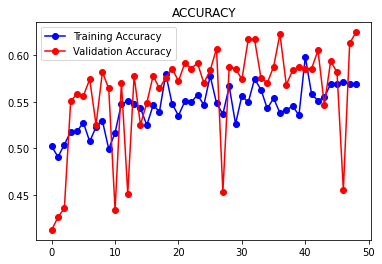

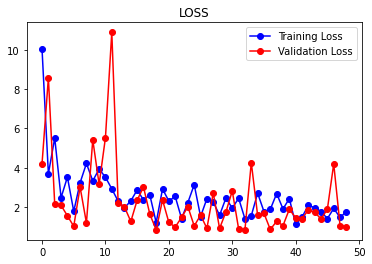

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

[[119 100]
 [ 47  70]]
              precision    recall  f1-score   support

           0       0.72      0.54      0.62       219
           1       0.41      0.60      0.49       117

    accuracy                           0.56       336
   macro avg       0.56      0.57      0.55       336
weighted avg       0.61      0.56      0.57       336



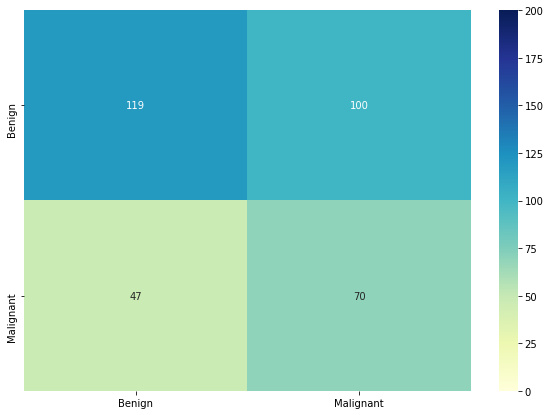

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

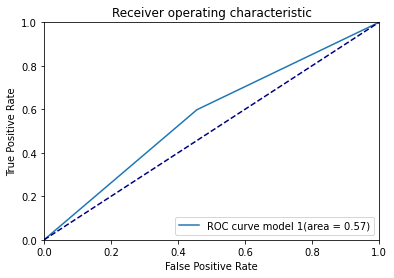

In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd

fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,predictions)

roc_auc1 = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve model 1(area = %0.2f)' % roc_auc1)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Experiment 19 - Best multimodal architecture

## Model creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini/'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image[0].reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    reshaped_image = image[1].reshape((150,150,1))
    rgb_image2 = np.repeat(reshaped_image, 3, 2)
    rgb_image2 = rgb_image / 65535
    tmp_images.append((rgb_image,rgb_image2))

  tmp_images = np.array(tmp_images)
  return tmp_images

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
# transform array in pairs of (baseline,patch)
N = len(images)
tmp = []
for i in range(0,N,2):
  tmp1 = images[i]
  tmp2 = images[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
images = np.array(tmp)
print(images.shape)
print(len(images))
print(len(labels))

images = toRGB(images)
print(images.shape)

(2676, 2, 150, 150)
2676
2676
(2676, 2, 150, 150, 3)


In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import gray2rgb

import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
from keras.layers import Input
from keras import applications

input_shape = (150,150,3)
model1 = models.Sequential()
model2 = models.Sequential()
pretrained_model1 = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(150,150,3))
pretrained_model2 = tf.keras.models.load_model(os.path.join(out_path, "models/pretrained_vgg16_trainable_bm"))
pretrained_model2.trainable = False
model1.add(pretrained_model1)
model2.add(pretrained_model2.layers[-5])
left_input = Input(input_shape)
right_input = Input(input_shape)

model1 = model1(left_input)
model2 = model2(right_input)    

In [ ]:
# Add a customized layer to compute the absolute difference between the encodings
from keras.layers.core import Lambda
from keras import backend as K
L1_layer = Lambda(lambda tensors: K.concatenate((tensors[0], tensors[1]),axis=-1))
L1_distance = L1_layer([model1, model2])

flatten = tf.keras.layers.Flatten()(L1_distance)
dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(256,activation='relu')(dense1)
prediction = tf.keras.layers.Dense(1,activation='sigmoid')(dense2)

# Connect the inputs with the outputs
model = models.Model(inputs=[left_input,right_input],outputs=prediction)

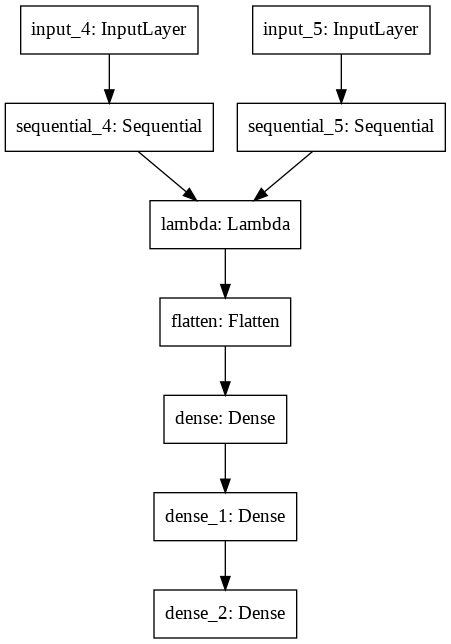

In [ ]:
tf.keras.utils.plot_model(model, to_file="img.png", show_shapes=False)

In [ ]:
from keras.utils import Sequence
class DoubleGenerator(Sequence):
    def __init__(self, gen1, gen2):
       self.gen1 = gen1
       self.gen2 = gen2

    def __len__(self):
       return len(self.gen1)

    def __getitem__(self, i):
       x1,y = self.gen1[i]
       x2,y2 = self.gen2[i]
       return (x1,x2), y

In [ ]:
from sklearn.model_selection import train_test_split
# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]
images_train, images_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


tmp_train = np.split(images_train, 2, axis=1)
tmp_valid = np.split(images_val, 2, axis=1)

tmp_train[0] = tmp_train[0].reshape((2007,150,150,3))
tmp_train[1] = tmp_train[1].reshape((2007,150,150,3))
tmp_valid[0] = tmp_valid[0].reshape((669,150,150,3))
tmp_valid[1] = tmp_valid[1].reshape((669,150,150,3))

print(labels_train.shape)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator()

train_generator = DoubleGenerator(datagen.flow(tmp_train[0],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[1],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED))



valid_generator = DoubleGenerator(valid_datagen.flow(tmp_valid[0],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[1],
                               labels_val,
                               batch_size=32,
                               seed=SEED))

# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

(2007,)
Epoch 1/250
63/63 [==============================] - 54s 708ms/step - loss: 0.7012 - accuracy: 0.4790 - val_loss: 0.6729 - val_accuracy: 0.6054

Epoch 00001: val_loss improved from inf to 0.67292, saving model to /tmp/checkpoint
Epoch 2/250
63/63 [==============================] - 42s 671ms/step - loss: 0.6846 - accuracy: 0.5925 - val_loss: 0.7100 - val_accuracy: 0.4126

Epoch 00002: val_loss did not improve from 0.67292
Epoch 3/250
63/63 [==============================] - 43s 680ms/step - loss: 0.6763 - accuracy: 0.5539 - val_loss: 0.6648 - val_accuracy: 0.6158

Epoch 00003: val_loss improved from 0.67292 to 0.66477, saving model to /tmp/checkpoint
Epoch 4/250
63/63 [==============================] - 43s 677ms/step - loss: 0.6817 - accuracy: 0.5795 - val_loss: 0.6800 - val_accuracy: 0.5904

Epoch 00004: val_loss did not improve from 0.66477
Epoch 5/250
63/63 [==============================] - 43s 682ms/step - loss: 0.6687 - accuracy: 0.6036 - val_loss: 0.6574 - val_accuracy: 0

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/baseline_multimodal_bm"))
with open(out_path+'/histories/baseline_multimodal_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Baseline/mmdf_different_networks_bm/assets


## Model evaluation

In [15]:
with open(out_path + '/histories/baseline_multimodal_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_bm"))

In [9]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  48
Accuracy:  0.6392625570297241
Loss:  0.6230326294898987
Val accuracy:  0.6472346782684326
Val loss:  0.62493497133255


In [ ]:


# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')

test_images_labels = change_label(test_images_labels[1::2])

# transform array in pairs of (baseline,patch)
N = len(test_images_tensor)
tmp = []
for i in range(0,N,2):
  tmp1 = test_images_tensor[i]
  tmp2 = test_images_tensor[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
test_images_tensor = np.array(tmp)
print(test_images_tensor.shape)


test_images_tensor = toRGB(test_images_tensor)
print(test_images_tensor.shape)

tmp_test = np.split(test_images_tensor, 2, axis=1)
tmp_test[0] = tmp_test[0].reshape((336,150,150,3))
tmp_test[1] = tmp_test[1].reshape((336,150,150,3))

test_loss, test_acc = model.evaluate((tmp_test[0], tmp_test[1]),test_images_labels)

(336, 2, 150, 150)
(336, 2, 150, 150, 3)
11/11 [==============================] - 11s 205ms/step - loss: 0.6920 - accuracy: 0.6190


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


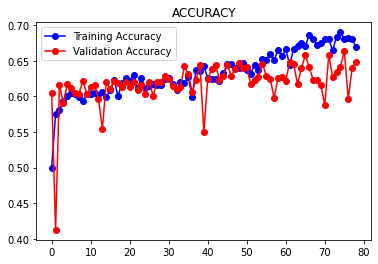

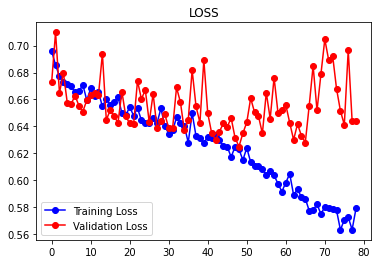

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

[[172  47]
 [ 81  36]]
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       219
           1       0.43      0.31      0.36       117

    accuracy                           0.62       336
   macro avg       0.56      0.55      0.54       336
weighted avg       0.59      0.62      0.60       336



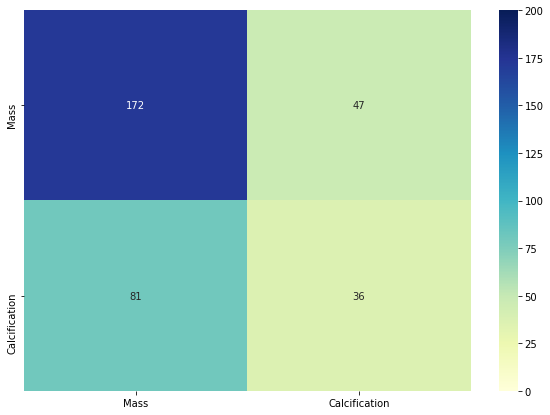

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

# Experiment 20 - Best Siamese Architecture

## Model creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini/'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image[0].reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    reshaped_image = image[1].reshape((150,150,1))
    rgb_image2 = np.repeat(reshaped_image, 3, 2)
    rgb_image2 = rgb_image / 65535
    tmp_images.append((rgb_image,rgb_image2))

  tmp_images = np.array(tmp_images)
  return tmp_images

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
# transform array in pairs of (baseline,patch)
N = len(images)
tmp = []
for i in range(0,N,2):
  tmp1 = images[i]
  tmp2 = images[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
images = np.array(tmp)
print(images.shape)
print(len(images))
print(len(labels))

images = toRGB(images)
print(images.shape)

(2676, 2, 150, 150)
2676
2676
(2676, 2, 150, 150, 3)


In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
from skimage.color import gray2rgb

import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
from keras.layers import Input
from keras import applications

input_shape = (150,150,3)
model = models.Sequential()

pretrained_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(150,150,3))
model.add(pretrained_model)

left_input = Input(input_shape)
right_input = Input(input_shape)

model1 = model(left_input)
model2 = model(right_input)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Add a customized layer to compute the absolute difference between the encodings
from keras.layers.core import Lambda
from keras import backend as K
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([model1, model2])

flatten = tf.keras.layers.Flatten()(L1_distance)
dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(256,activation='relu')(dense1)
prediction = tf.keras.layers.Dense(1,activation='sigmoid')(dense2)

# Connect the inputs with the outputs
model = models.Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
from keras.utils import Sequence
class DoubleGenerator(Sequence):
    def __init__(self, gen1, gen2):
       self.gen1 = gen1
       self.gen2 = gen2

    def __len__(self):
       return len(self.gen1)

    def __getitem__(self, i):
       x1,y = self.gen1[i]
       x2,y2 = self.gen2[i]
       return (x1,x2), y

In [ ]:
from sklearn.model_selection import train_test_split
# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]
images_train, images_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

tmp_train = np.split(images_train, 2, axis=1)
tmp_valid = np.split(images_val, 2, axis=1)

tmp_train[0] = tmp_train[0].reshape((2007,150,150,3))
tmp_train[1] = tmp_train[1].reshape((2007,150,150,3))
tmp_valid[0] = tmp_valid[0].reshape((669,150,150,3))
tmp_valid[1] = tmp_valid[1].reshape((669,150,150,3))

print(labels_train.shape)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator()

train_generator = DoubleGenerator(datagen.flow(tmp_train[0],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[1],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED))



valid_generator = DoubleGenerator(valid_datagen.flow(tmp_valid[0],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[1],
                               labels_val,
                               batch_size=32,
                               seed=SEED))


# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

(2007,)
Epoch 1/250
63/63 [==============================] - 104s 1s/step - loss: 0.6896 - accuracy: 0.4822 - val_loss: 0.6876 - val_accuracy: 0.5590

Epoch 00001: val_loss improved from inf to 0.68757, saving model to /tmp/checkpoint
Epoch 2/250
63/63 [==============================] - 85s 1s/step - loss: 0.6826 - accuracy: 0.5496 - val_loss: 0.6878 - val_accuracy: 0.5247

Epoch 00002: val_loss did not improve from 0.68757
Epoch 3/250
63/63 [==============================] - 85s 1s/step - loss: 0.6776 - accuracy: 0.5246 - val_loss: 0.6622 - val_accuracy: 0.5919

Epoch 00003: val_loss improved from 0.68757 to 0.66224, saving model to /tmp/checkpoint
Epoch 4/250
63/63 [==============================] - 85s 1s/step - loss: 0.6783 - accuracy: 0.5693 - val_loss: 0.6648 - val_accuracy: 0.5949

Epoch 00004: val_loss did not improve from 0.66224
Epoch 5/250
63/63 [==============================] - 85s 1s/step - loss: 0.6625 - accuracy: 0.6056 - val_loss: 0.6548 - val_accuracy: 0.6024

Epoch 0

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/baseline_siamese_bm"))
with open(out_path+'/histories/baseline_siamese_bm_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/Baseline/siamese_vgg_bm/assets


## Model evaluation

In [16]:
with open(out_path + '/histories/baseline_siamese_bm_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_siamese_bm"))

In [17]:
index = history['val_loss'].index(min(history['val_loss']))
print("Epochs: ", index)
print("Accuracy: ", history['accuracy'][index])
print("Loss: ", history['loss'][index])
print("Val accuracy: ", history['val_accuracy'][index])
print("Val loss: ", history['val_loss'][index])

Epochs:  48
Accuracy:  0.6307922005653381
Loss:  0.6282869577407837
Val accuracy:  0.6472346782684326
Val loss:  0.6339156627655029


In [ ]:

# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_labels = change_label(test_images_labels[1::2])

# transform array in pairs of (baseline,patch)
N = len(test_images_tensor)
tmp = []
for i in range(0,N,2):
  tmp1 = test_images_tensor[i]
  tmp2 = test_images_tensor[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
test_images_tensor = np.array(tmp)
print(test_images_tensor.shape)

test_images_tensor = toRGB(test_images_tensor)
print(test_images_tensor.shape)

tmp_test = np.split(test_images_tensor, 2, axis=1)
tmp_test[0] = tmp_test[0].reshape((336,150,150,3))
tmp_test[1] = tmp_test[1].reshape((336,150,150,3))

test_loss, test_acc = model.evaluate((tmp_test[0], tmp_test[1]),test_images_labels)

(336, 2, 150, 150)
(336, 2, 150, 150, 3)
11/11 [==============================] - 11s 210ms/step - loss: 0.7039 - accuracy: 0.5863


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


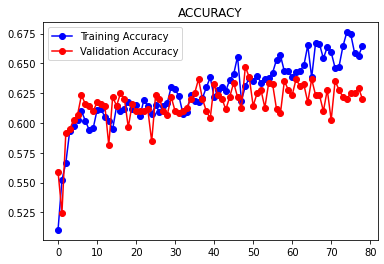

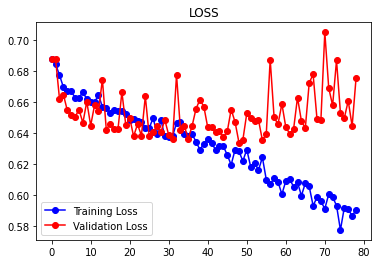

In [ ]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

[[142  77]
 [ 62  55]]
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       219
           1       0.42      0.47      0.44       117

    accuracy                           0.59       336
   macro avg       0.56      0.56      0.56       336
weighted avg       0.60      0.59      0.59       336



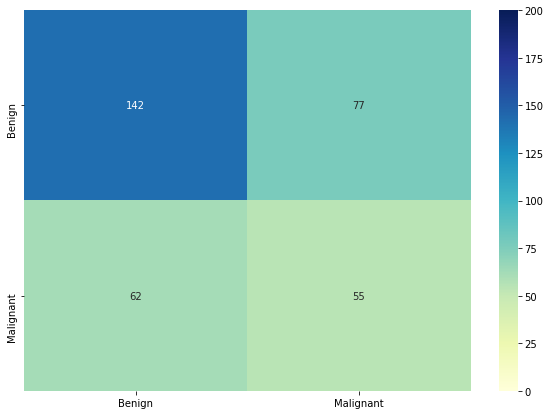

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Benign", "Malignant"],
                  columns = ["Benign", "Malignant"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))